# Package Installation

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bryanfores/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bryanfores/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bryanfores/nltk_data...


True

# Text Preprocessing

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Sentiment analysis using TextBlob (requires installing the textblob library)
from textblob import TextBlob

#topic analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [47]:
# Load the dataset
df = pd.read_csv('../data/intv_data.csv')

# Clean and preprocess the text data
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is not NaN
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        text = " ".join(text.split())
        # Tokenize the text into words
        tokens = word_tokenize(text)
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatize or stem the words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Join the tokens back into a single string
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text
    else:
        return np.nan

# Apply preprocessing to the 'OQ*' column
df['preprocessed_text'] = df['OQ8'].apply(preprocess_text)


# Exploratory Data Analysis, Sentiment Analysis

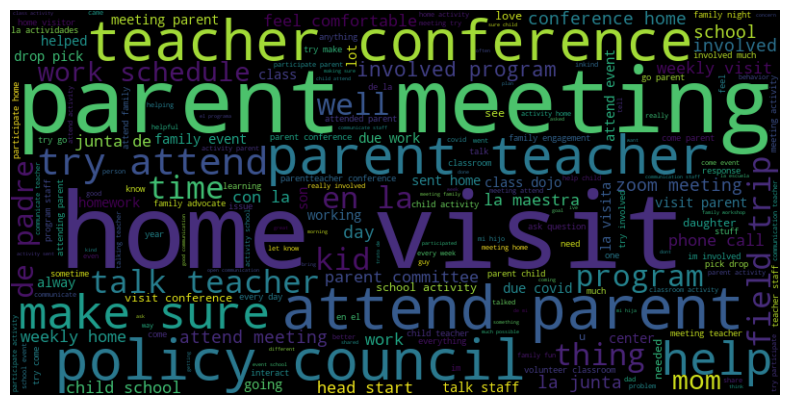

/var/folders/vw/1sthm_ts1dj_1hqg1xnsz19w0000gn/T/ipykernel_84338/2683674642.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['response_length'] = filtered_df['preprocessed_text'].apply(lambda x: len(x.split()))
/var/folders/vw/1sthm_ts1dj_1hqg1xnsz19w0000gn/T/ipykernel_84338/2683674642.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sentiment'] = filtered_df['preprocessed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
/var/folders/vw/1sthm_ts1dj_1hqg1xnsz19w0000gn/T

In [48]:
# Filter out NaN values
filtered_df = df.dropna(subset=['preprocessed_text'])

# Visualize word cloud of most common words
wordcloud = WordCloud(width=800, height=400).generate(' '.join(filtered_df['preprocessed_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Calculate response lengths
filtered_df['response_length'] = filtered_df['preprocessed_text'].apply(lambda x: len(x.split()))

filtered_df['sentiment'] = filtered_df['preprocessed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
filtered_df['sentiment2'] = filtered_df['sentiment']


In [61]:
from transformers import pipeline

# Specify the model explicitly
sentiment_analysis = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Example text
text = "I view it more as a daycare than a preschool"

# Perform sentiment analysis
result = sentiment_analysis(text)

# Output the result
print(result)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


[{'label': 'NEGATIVE', 'score': 0.9384480714797974}]


# Recalibrating Sentiment Scores

In [49]:
# Normalizing Q24 and Q25 scores
filtered_df['normalized_Q24'] = (filtered_df['Q24'] - 3) / 2
filtered_df['normalized_Q25'] = (filtered_df['Q25'] - 3) / 2

# Calculating Composite Sentiment Score
# Assigning weights (you can change these values based on your preference)
w1 = 0.33
w2 = 0.17
w3 = 0.50

filtered_df['composite_sentiment_score'] = (w1 * filtered_df['sentiment'] +
                                   w2 * filtered_df['normalized_Q24'] +
                                   w3 * filtered_df['normalized_Q25'])

# Classifying Composite Sentiment Score into categories
def classify_sentiment(composite_score):
    if composite_score < -0.5:
        return 'negative'
    elif composite_score > 0.5:
        return 'positive'
    else:
        return 'neutral'

filtered_df['sentiment_category'] = filtered_df['composite_sentiment_score'].apply(classify_sentiment)

/var/folders/vw/1sthm_ts1dj_1hqg1xnsz19w0000gn/T/ipykernel_84338/3923896462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['normalized_Q24'] = (filtered_df['Q24'] - 3) / 2
/var/folders/vw/1sthm_ts1dj_1hqg1xnsz19w0000gn/T/ipykernel_84338/3923896462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['normalized_Q25'] = (filtered_df['Q25'] - 3) / 2
/var/folders/vw/1sthm_ts1dj_1hqg1xnsz19w0000gn/T/ipykernel_84338/3923896462.py:11: SettingWithCopyWarning: 
A value is trying to be se

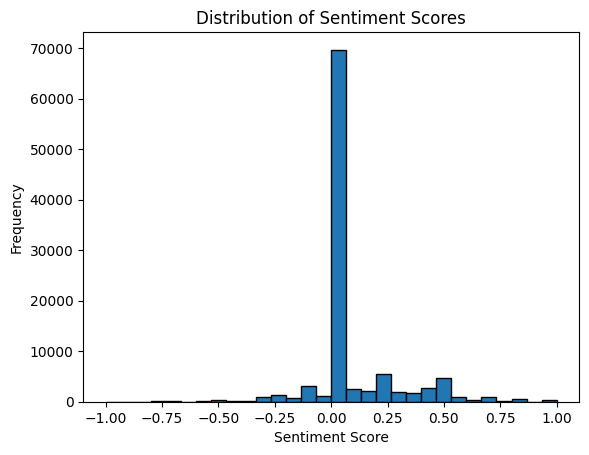

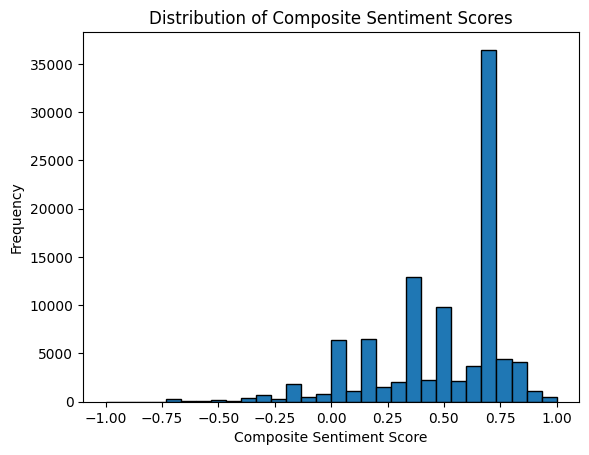

In [50]:
# Plot histogram of sentiment scores
plt.hist(filtered_df['sentiment'], bins=30, edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

# Plot histogram of sentiment scores
plt.hist(filtered_df['composite_sentiment_score'], bins=30, edgecolor='black')
plt.xlabel('Composite Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Composite Sentiment Scores')
plt.show()

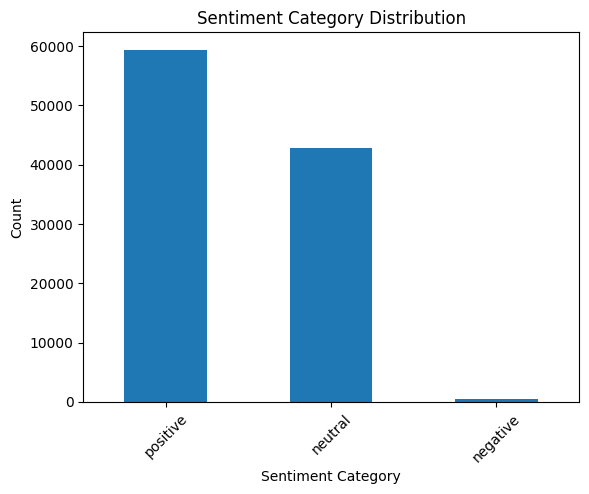

In [51]:
# Categorize sentiment scores
#filtered_df['sentiment3'] = filtered_df['sentiment2']
#filtered_df['sentiment_category'] = pd.cut(filtered_df['sentiment'], bins=[-1, -0.1, 0.1, 1], labels=['negative', 'neutral', 'positive'])

# Count the number of responses in each sentiment category
sentiment_counts = filtered_df['sentiment_category'].value_counts()

# Plot bar chart of sentiment category counts
sentiment_counts.plot(kind='bar')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Category Distribution')
plt.xticks(rotation=45)
plt.show()

# Topic Modeling with LDA

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Filter out NaN values and negative sentiment_category
filtered_df = filtered_df[filtered_df['sentiment_category'] == 'negative']
filtered_df = filtered_df.dropna(subset=['preprocessed_text'])

# Vectorize the preprocessed text
vectorizer = CountVectorizer(max_features=1000, max_df=0.95, min_df=2, stop_words='english')
vectorized_data = vectorizer.fit_transform(filtered_df['preprocessed_text'])

# Get the feature names from the vectorizer as a list
feature_names = list(vectorizer.get_feature_names_out())

# Apply Latent Dirichlet Allocation (LDA)
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_output = lda_model.fit_transform(vectorized_data)

# Get the main topics and their top keywords
n_top_words = 10
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keywords = [feature_names[i] for i in topic_weights.argsort()[:-n_top_words - 1:-1]]
    topic_keywords.append(', '.join(top_keywords))

# Assign topics to the responses
filtered_df['topic'] = lda_output.argmax(axis=1)
filtered_df['topic_keywords'] = filtered_df['topic'].map(lambda x: topic_keywords[x])

In [53]:
# Count the number of responses per topic
topic_counts = filtered_df['topic'].value_counts().sort_index()

# Generate the topic analysis output
output = ""
output += "Topic Analysis:\n\n"

for topic_id, topic_keywords in enumerate(topic_keywords):
    output += f"Topic {topic_id}:\n"
    output += f"Keywords: {topic_keywords}\n"
    output += f"Number of responses: {topic_counts[topic_id]}\n"
    output += "\n"

# Print the output
print(output)

Topic Analysis:

Topic 0:
Keywords: na, family, answer, night, question, advocate, parent, asked, engagement, basis
Number of responses: 68

Topic 1:
Keywords: help, child, work, make, sure, able, school, im, need, day
Number of responses: 24

Topic 2:
Keywords: teacher, talk, child, staff, day, program, involved, shared, class, year
Number of responses: 40

Topic 3:
Keywords: really, covid, teacher, center, come, like, dont, issue, little, talking
Number of responses: 22

Topic 4:
Keywords: like, havent, guess, thing, covid, hard, know, chance, la, ask
Number of responses: 25

Topic 5:
Keywords: meeting, child, parent, time, participate, school, policy, council, know, volunteer
Number of responses: 44

Topic 6:
Keywords: classroom, event, parent, meeting, dont, try, drop, school, attended, zoom
Number of responses: 39

Topic 7:
Keywords: activity, home, visit, parent, conference, teacher, child, phone, sent, attend
Number of responses: 45

Topic 8:
Keywords: involved, work, program, i

In [54]:

# Write the updated dataframe to .csv file
filtered_df.to_csv('../data/sentiment_analysis.csv', index=False)

In [55]:
topic_sentiment = filtered_df.groupby('topic')['composite_sentiment_score'].mean()

print(topic_sentiment)

topic
0   -0.652296
1   -0.578339
2   -0.647004
3   -0.626907
4   -0.647191
5   -0.640048
6   -0.637083
7   -0.627572
8   -0.631410
9   -0.629118
Name: composite_sentiment_score, dtype: float64


## Interpretations

Topic 0 - Communication Challenges
Keywords: year, covid, like, don't, feel, involved, difficult, hard, really, week
Interpretation: This topic seems to highlight the difficulties and frustrations parents are experiencing due to COVID-19, which has likely affected regular communication and involvement with the program.

Topic 1 - Daily School Experience
Keywords: school, child, everyday, teacher, bring, sick, class, kid, help, zoom
Interpretation: Parents appear to be expressing concerns about their child's daily school experiences, including the challenges of managing illness, remote learning (as indicated by "zoom"), and communication with teachers.

Topic 2 - Family Events
Keywords: family, start, trip, time, field, head, night, went, come, parenting
Interpretation: This topic may represent concerns about family events and activities associated with the program. Parents might be finding it difficult to participate in these activities or are unsatisfied with them.

Topic 3 - Staff Interaction
Keywords: staff, talk, covid, teacher, everyday, pick, drop, know, interact, hard
Interpretation: Parents seem to be expressing negative sentiments regarding interactions with staff, possibly related to drop-off and pick-up procedures, or general communication barriers.

Topic 4 - Involvement in the Program
Keywords: involved, program, center, getting, time, health, hard, needed, like, I'm
Interpretation: Parents may be finding it challenging to get involved with the program and feel like they're struggling to navigate the health-related aspects or time commitments of the program.

Topic 5 - Scheduling Conflicts
Keywords: work, schedule, hard, involved, try, unable, attend, make, participate, activity
Interpretation: This topic reflects the struggle parents face trying to align their work schedule with the activities of the program, making participation difficult.

Topic 6 - Child's Involvement
Keywords: little, active, day, help, teacher, stay, try, class, child, going
Interpretation: Parents seem to be having difficulty keeping their children active and involved in the class, and might be seeking more help from teachers.

Topic 7 - Parental Participation
Keywords: center, parent, meeting, event, attend, activity, participate, volunteer, teacher, come
Interpretation: This topic seems to indicate that parents are finding it hard to attend meetings, events, and volunteering activities at the center.

Topic 8 - Policy and Classroom Issues
Keywords: policy, council, classroom, event, come, family, hard, past, mom, parent
Interpretation: Parents might be expressing dissatisfaction with the policies of the program or classroom-related issues.

Topic 9 - Home-Based Activities
Keywords: home, visit, activity, center, conference, parent, base, weekly, socialization, participate
Interpretation: This topic appears to revolve around parents' struggles to manage home-based activities or visits, possibly indicating difficulties with balancing program requirements with their own schedules or commitments.

# Clustering and Classification

In [79]:
from sklearn.metrics import silhouette_score

# Perform clustering using K-means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(vectorized_data)

labels = kmeans.predict(vectorized_data)

# Evaluate the clustering
silhouette_avg = silhouette_score(vectorized_data, labels)
output = f"Clustering Evaluation:\nSilhouette Score: {silhouette_avg}\n\n"

# Perform classification using Support Vector Machines (SVM)
X_train, X_test, y_train, y_test = train_test_split(vectorized_data, labels, test_size=0.2, random_state=42)
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Generate classification report
classification_rep = classification_report(y_test, y_pred)
output += f"Classification Report:\n{classification_rep}"

# Print the output
print(output)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering Evaluation:
Silhouette Score: 0.3563051512033781

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       743
           1       0.97      1.00      0.98     23066
           2       0.99      0.69      0.81       799
           3       1.00      0.91      0.95      1450
           4       0.99      0.91      0.95      2410

    accuracy                           0.97     28468
   macro avg       0.99      0.85      0.91     28468
weighted avg       0.97      0.97      0.97     28468



## Further Analysis

In [25]:
Identify demographics of key topic responses

#comparison of responses of initial vs mid/post interviews
#comparison of responses of racial, socioeconomic demographics



SyntaxError: invalid syntax (2651188324.py, line 1)

In [ ]:
## Fine tuning pre-trained roBERTa model

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

# Load a pre-trained model and tokenizer
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load and preprocess your dataset (assuming it's in a csv file)
dataset = load_dataset('csv', data_files={'train': 'path_to_train.csv', 'validation': 'path_to_validation.csv'})
tokenized_dataset = dataset.map(lambda examples: tokenizer(examples['text'], truncation=True, padding='max_length'), batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
)

# Fine-tune the model
trainer.train()